In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.cluster import KMeans
from datasets import load_dataset
import os

In [2]:
num_clusters = 6

# Extract LAB Values

In [13]:
def extract_lab_features(image):
    image = np.array(image)
    # Identify black pixels in the original image (RGB values are all zero)
    black_mask = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) == 0
    # Create an inverse mask for non-black pixels
    non_black_mask = ~black_mask

    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    L_channel, A_channel, B_channel = cv2.split(lab_image)

    # Apply the non-black mask to each channel
    L_non_black = L_channel[non_black_mask]
    A_non_black = A_channel[non_black_mask]
    B_non_black = B_channel[non_black_mask]

    if L_non_black.size == 0:
        l_mean = 0
        a_mean = 0
        b_mean = 0
    else:
        l_mean = np.mean(L_non_black)
        a_mean = np.mean(A_non_black)
        b_mean = np.mean(B_non_black)

    return l_mean, a_mean, b_mean

In [14]:
images = []
l_values = []
a_values = []
b_values = []

In [15]:
dataset = load_dataset("e1010101/tongue-images-all-segmented")

In [16]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'pixel_values'],
        num_rows: 894
    })
})

In [17]:
for image_file in tqdm(dataset['train']['image'], desc="Parsing images"):
    l_mean, a_mean, b_mean = extract_lab_features(image_file)
    
    images.append(image_file)
    l_values.append(l_mean)
    a_values.append(a_mean)
    b_values.append(b_mean)

Parsing images: 100%|██████████| 894/894 [00:03<00:00, 271.96it/s]


In [18]:
df = pd.DataFrame({
    'image': images,
    'L': l_values,
    'A': a_values,
    'B': b_values
})

In [27]:
np.array(df.iloc[0]['image'])

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

# K-Means Clustering

In [19]:
X = df[['A', 'B']]
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(X)
df['cluster'] = kmeans.labels_
df

c:\Users\ezrat\anaconda3\envs\Project\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


,image,L,A,B,cluster
0,<PIL.PngImagePlugin.PngImageFile image mode=RG...,109.906704,144.461845,87.632855,2
1,<PIL.PngImagePlugin.PngImageFile image mode=RG...,139.812455,136.244694,108.171157,3
2,<PIL.PngImagePlugin.PngImageFile image mode=RG...,169.732837,136.231401,115.012246,1
3,<PIL.PngImagePlugin.PngImageFile image mode=RG...,133.540616,141.736914,92.538748,2
4,<PIL.PngImagePlugin.PngImageFile image mode=RG...,139.300059,143.647446,101.140597,4
...,...,...,...,...,...
889,<PIL.PngImagePlugin.PngImageFile image mode=RG...,120.889346,143.558004,108.020947,4
890,<PIL.PngImagePlugin.PngImageFile image mode=RG...,165.328814,140.208544,82.148655,5
891,<PIL.PngImagePlugin.PngImageFile image mode=RG...,88.654365,136.690274,101.609631,0
892,<PIL.PngImagePlugin.PngImageFile image mode=RG...,109.723155,137.196701,115.435350,1


# Visualizations

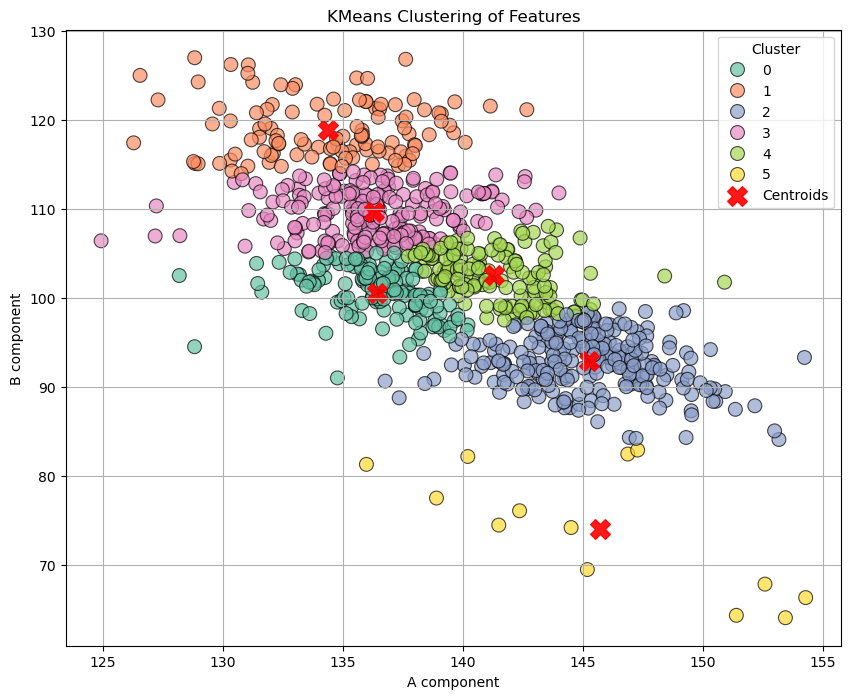

In [20]:
centers = kmeans.cluster_centers_

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df,
    x='A',
    y='B',
    hue='cluster',
    palette='Set2',
    s=100,
    edgecolor='k',
    alpha=0.7
)

# Plot the cluster centers
plt.scatter(
    centers[:, 0],
    centers[:, 1],
    c='red',
    s=200,
    alpha=0.9,
    marker='X',
    label='Centroids'
)

# Customize the plot
plt.title('KMeans Clustering of Features')
plt.xlabel('A component')
plt.ylabel('B component')
plt.legend(title='Cluster', loc='best')
plt.grid(True)
plt.show()

# Image Saving

In [11]:
def save_clustered_images(df, base_output_dir):
    os.makedirs(base_output_dir, exist_ok=True)
    
    for cluster in df['cluster'].unique():
        cluster_dir = os.path.join(base_output_dir, f'cluster_{cluster}')
        os.makedirs(cluster_dir, exist_ok=True)
        cluster_images = df[df['cluster'] == cluster]
        
        for idx, row in cluster_images.iterrows():
            image = row['image']
            image_path = os.path.join(cluster_dir, f'image_{idx}.jpg')
            image.save(image_path)

    print("Image saving complete")

In [12]:
output_directory = "clusters/clustered_images"
save_clustered_images(df, output_directory)


Image saving complete
